In [42]:
import os
from shutil import copyfile
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from PIL import Image

# Preparing the data structure

In [23]:
weather_list = ['Cloudy', 'Foggy', 'Snowy', 'Sunny', 'Rainy']

In [24]:
os.mkdir(r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\training')
os.mkdir(r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\testing')

In [25]:
for weather in weather_list:
    os.mkdir(os.path.join(r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\training', weather))

In [26]:
os.mkdir(os.path.join(r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\testing', 'test'))

In [27]:
base_path = r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\Rome Weather'
training_path = r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\training'
testing_path = r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\testing'
test_path = r'C:\Users\Sahil\DS ML tests\Project Rome Weather prediction\testing\test'

In [28]:
#create training data
for weather in os.listdir(base_path):
    img_path = os.path.join(base_path, weather)
    count = 0
    
    for image in os.listdir(img_path):
        if count == 40:
            break
        source = os.path.join(img_path, image)
        dest = os.path.join(training_path, weather,  image)
        count += 1
        copyfile(source, dest)

In [29]:
#create testing data
for weather in os.listdir(base_path):
    img_path = os.path.join(base_path, weather)
    
    for image in os.listdir(img_path)[-10:]:
      
        source = os.path.join(img_path, image)
        dest = os.path.join(test_path,  image)
        copyfile(source, dest)

# Visualising the data

Cloudy
Shape of image (194, 259, 3)


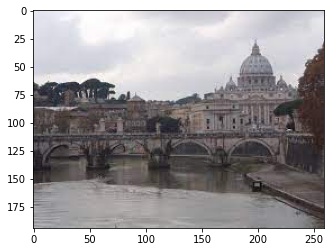

Foggy
Shape of image (183, 275, 3)


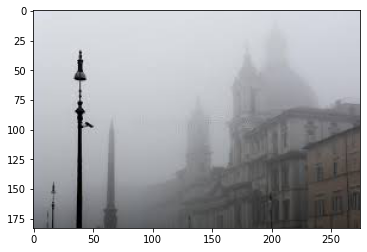

Rainy
Shape of image (183, 276, 3)


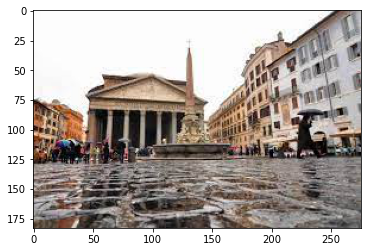

Snowy
Shape of image (168, 299, 3)


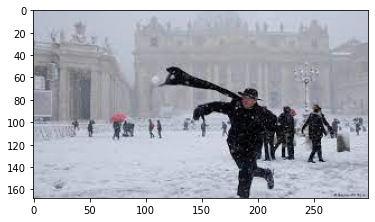

Sunny
Shape of image (181, 278, 3)


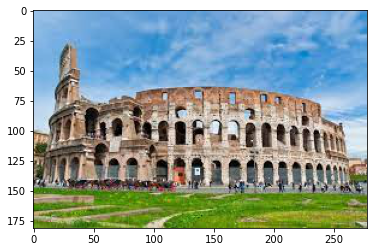

In [32]:
for weather in os.listdir(base_path):
    img_path = os.path.join(base_path, weather)
    print(weather)
    for img in os.listdir(img_path):
        img_array = mpimg.imread(os.path.join(img_path, img))
        print('Shape of image',  img_array.shape)
        plt.imshow(img_array)
        plt.show()
        break
        
        

As we can see that all images are of different size.

# Preparing the datagen directory

In [33]:
#defining target image size and batch size
image_size = (240, 240)
batch_size = 8
val_size = 0.2

In [38]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = val_size)

train_generator = train_datagen.flow_from_directory(training_path, 
                                                   target_size = image_size,
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   seed = 10,
                                                   subset = 'training')



val_generator = train_datagen.flow_from_directory(
                                                    training_path,
                                                    target_size = image_size,
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = 10,
                                                    subset = 'validation'
                                        
                                                  )

Found 160 images belonging to 5 classes.
Found 40 images belonging to 5 classes.


In [39]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                                                    testing_path,
                                                    target_size = image_size,
                                                    classes = ['test'],
                                                    batch_size = batch_size
                                                  )

Found 20 images belonging to 1 classes.


In [46]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Snowy', 4: 'Sunny'}

# Building Model

In [41]:
model = keras.Sequential([
    #CNN1
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (image_size[0], image_size[1],3)),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.3),
    
    #CNN2
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.3),
    
     #CNN3
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.2),
    
    #CNN4
    layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2, padding = 'same'),
    layers.Dropout(0.3),
    
     #Hidden Layers 
    layers.Flatten(),
    layers.Dense(units = 512, activation = 'relu'),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dropout(0.2),
    
    #Output Layer
    layers.Dense(units = 5, activation = 'softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 119, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 59, 59, 64)        0

In [47]:
#compiling the model
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
#adding callback condition
cb = EarlyStopping(monitor = 'val_accuracy', patience = 3, min_delta = 0.01, verbose = 1)

In [52]:
hist = model.fit(train_generator, epochs = 50, validation_data = val_generator)

Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 1.0829 - accuracy: 0.5875 - val_loss: 1.0145 - val_accuracy: 0.5750
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 1.1846 - accuracy: 0.5750 - val_loss: 1.2350 - val_accuracy: 0.4500
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 0.9721 - accuracy: 0.5813 - val_loss: 1.0773 - val_accuracy: 0.6250
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 0.9143 - accuracy: 0.6250 - val_loss: 0.8216 - val_accuracy: 0.6250
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 0.8138 - accuracy: 0.6438 - val_loss: 1.0383 - val_accuracy: 0.6250
Epoch 6/50
10/10 [==============================] - 21s 2s/step - loss: 0.8248 - accuracy: 0.6625 - val_loss: 1.0104 - val_accuracy: 0.6000
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 0.8194 - accuracy: 0.7000 - val_loss: 1.1671 - val_accuracy: 0.5500
Epoch 8/50
10/10 [==

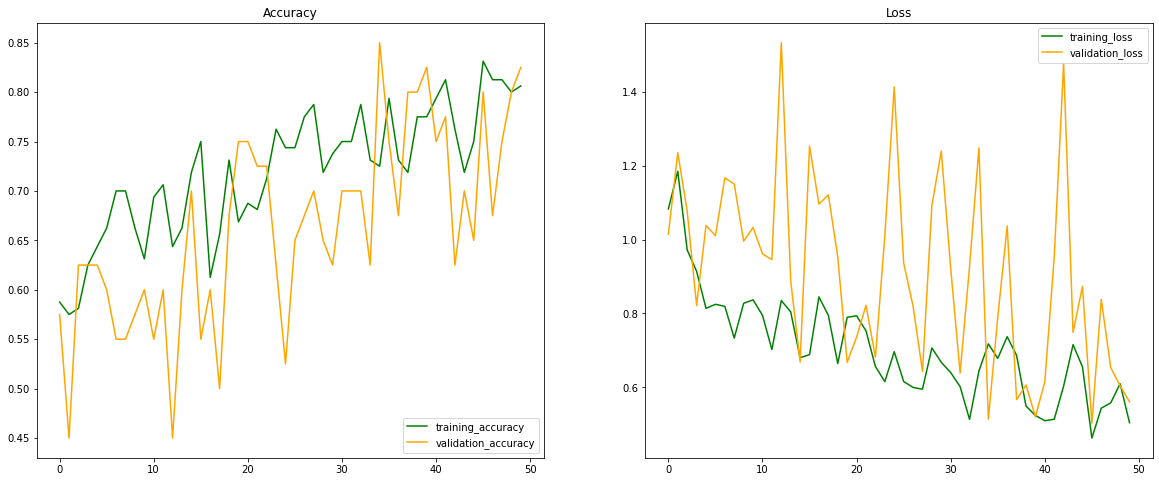

In [54]:
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(50)
plt.plot(epochs, train_acc, label = 'training_accuracy', color = 'green')
plt.plot(epochs, val_acc, label = 'validation_accuracy', color = 'orange')
plt.legend(loc = 'lower right')
plt.title('Accuracy')


plt.subplot(1, 2, 2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(50)
plt.plot(epochs, train_loss, label = 'training_loss', color = 'green')
plt.plot(epochs, val_loss, label = 'validation_loss', color = 'orange')
plt.legend(loc = 'upper right')
plt.title('Loss')

plt.show()



# Predicting for test data

In [57]:
data_batch[0].shape

(16, 240, 240, 3)

In [55]:
for data_batch in test_generator:
    pred = model.predict(data_batch[0])
    pred_indices = np.argmax(pred, axis = 1)
    break

1/1 [==============================] - 1s 749ms/step


In [56]:
pred_indices

array([1, 1, 4, 4, 4, 3, 4, 2, 1, 0, 4, 4, 0, 1, 4, 3], dtype=int64)

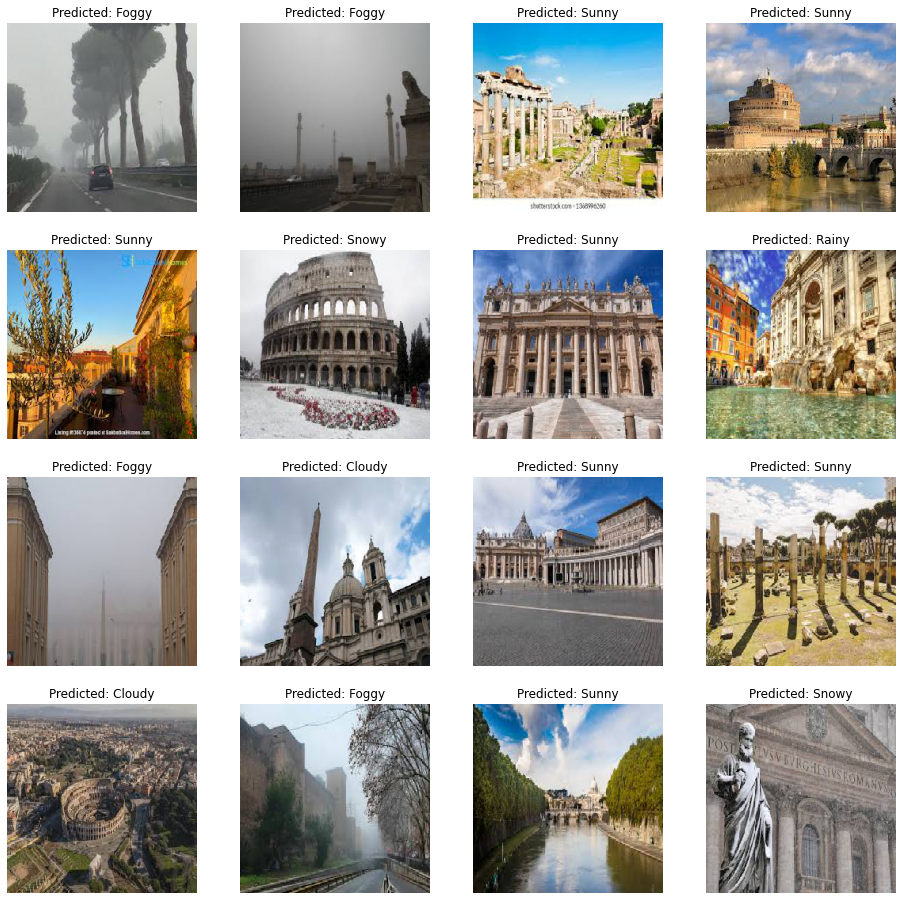

In [60]:
plt.figure(figsize = (16, 16))

for i in range(data_batch[0].shape[0]):
    plt.subplot(4, 4, i+1)
    pred_label = labels[pred_indices[i]]
    plt.imshow(data_batch[0][i])
    plt.title(f'Predicted: {pred_label}')
    plt.axis('off')